In [1]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd.numpy import trace
from autograd.numpy.linalg import det
from autograd.numpy.linalg import inv
from autograd.scipy.stats import norm
from autograd.scipy.special import gamma as gammaFn
from autograd.scipy.special import polygamma

from autograd import grad

%matplotlib inline

/home/local/ANT/ennalisn/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Operator Variational Inference
### by R. Ranganath, J. Altosaar, D. Tran, and D. Blei (https://arxiv.org/abs/1610.09033)

Variational inference (VI) refers to the task of optimizing the parameters of a distribution such that it approximates an intractable one well.  Because Bayesian posteriors are intractable in all but the simplest cases, VI is usually employed for Bayesian models as a scalable alternative to MCMC.  The optimization objective is usually chosen as the KL-Divergence from the approximate distribution to the intractable one (although there are less-popular alternatives): $$KLD[q(\theta) \mid \mid p(\theta|\mathcal{D})] = \int_{\theta} q(\theta) [\log q(\theta) - \log p(\theta|\mathcal{D})] d\theta = \int_{\theta} q(\theta) [\log q(\theta) - \log p(\mathcal{D}, \theta)] d\theta + \log p(\mathcal{D}).$$  Rearranging the above to put the model evidence on the LHS, we have $$\log p(\mathcal{D}) = \int_{\theta} q(\theta) [\log p(\mathcal{D},\theta) - \log q(\theta)] d\theta + KLD[q(\theta) \mid \mid p(\theta|\mathcal{D})] \ge \mathbb{E}_{q} [\log p(\mathcal{D}, \theta) - \log q(\theta)] = \mathcal{L}_{VI}.$$  $\mathcal{L}_{VI}$ is known as the *Evidence Lowerbound*, and it comes about by dropping the $KLD[q(\theta) \mid \mid p(\theta | \mathcal{D})]$ term, which we know is strictly non-negative.  Notice that the bound becomes tight when $q(\theta)=p(\theta | \mathcal{D})$.

### Operator Variational Inference

The usual approaches to VI (based on KLD and the evidence lowerbound above) hinge upon choosing a parametric form for the approximate posterior $q$.  Ranganath et al. argues that there are benefits to be had if we broaden our perspective of VI to think of it just as mapping one function to another---i.e. applying an *operator* $\mathcal{0}^{p,q}$.  There are three components to their Operator VI (OVI) framework:
* An operator $\mathcal{O}^{p,q}$ that depends on $q$ and $p(\theta | \mathcal{D})$.
* A family of test functions $f \in \mathcal{F}$ such that $f: \Theta \mapsto \mathbb{R}^d$.
* A distance function $t: \mathbb{R} \mapsto [0,\infty)$.

These components are combined to form the following OVI objective: $$\mathcal{L}_{OVI} = \sup_{f \in\mathcal{F}} t(\mathbb{E}_{q} [ (\mathcal{O}^{p,q} f)(\theta) ]), $$ which we desire to equal zero when $p(\theta | \mathcal{D})=q(\theta)$.  The operator $\mathcal{O}^{p,q}$, while still rather abstract at the moment, can be thought of as the posterior's sole source of influence.  

In [9]:
def steinOp(x, idx, dLogModel, params, kernel, kernelParams=None):
    returnVal = 0.
    n = len(x)
    for j in xrange(n):
        returnVal += kernel['f'](x[j], x[idx]) * dLogModel(x[j],params) + kernel['df'](x[j], x[idx])
    return 1./n * returnVal

### Gaussian Mixture Model

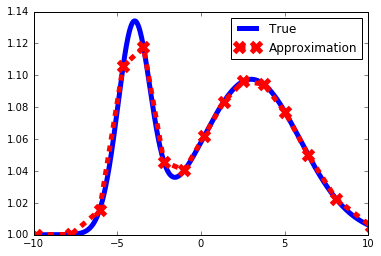

In [56]:
# Model
def gaussPdf(x, params):
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

def logGaussMixPDF(x, params):
    return params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]})
                                         
logModel = logGaussMixPDF
dLogModel = grad(logModel)
params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

# kernel
kernel = {'f': rbf}
kernel['df'] = grad(kernel['f'])

# initial distribution
q0 = np.random.normal

### generate samples
n = 15
x = []
for sampleIdx in xrange(n):
    x.append(q0())
    
maxEpochs = 100
lr = 2.
for epochIdx in xrange(maxEpochs):
    for idx in xrange(n):
        x[idx] += lr * steinOp(x, idx, dLogModel, params, kernel)

x.sort()
probs = [np.exp(logModel(z, params)) for z in x]    
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]

plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")
plt.plot(x, probs, 'rx--', markersize=10, mew=5, linewidth=5, label="Approximation")
plt.xlim([-10,10])
plt.legend()